
# Predicting Accidents in New York City
## Capstone Project 1
### Gene Hopping
### Springboard Data Science Career Track
## Part 2: Traffic Volume Data Wrangling
# Contents <a id='Contents'/>

[Data wrangling](#data_wrangling)

[EDA](#EDA)

[Conversion of latitude and longitude to mercator](#mercator)

[Plots]

[Generating the rastor]




We are interested in the rate of accidents on New York City Roads. To prdict that there is an increased chance of an accident, we need to normalize the accident data to ensure we're not just predicting when there are more cars on the road, and therefore more accidents.

The data most important to us is the date, time and traffic count. Unlike the accident data, which gives the geographical coordinates of the accidents, locations here are encoded as a text-based address. These data will serve as an approximation of city-wide traffic.

[Back to Contents](#Contents)

## Data Wrangling<a id='data_wrangling'/>

In [1]:
#import libraries
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
#import geopandas
#from osgeo import gdal
import seaborn as sns
import numpy as np
from pyproj import Proj, transform
from datetime import date, time, timedelta, datetime

In [2]:
#data_source = 'https://data.cityofnewyork.us/resource/qiz3-axqb.json'
#low_memory=False because error recieved: Columns (3) have mixed types
traffic_df = pd.read_csv('NYPD_Motor_Vehicle_Collisions.csv', low_memory=False) #parse_dates=[['DATE', 'TIME']]
volume_df = pd.read_csv('Traffic_Volume_Counts__2014-2018_.csv', low_memory=False)


In [3]:
volume_df.head()

,ID,Segment ID,Roadway Name,From,To,Direction,Date,12:00-1:00 AM,1:00-2:00AM,2:00-3:00AM,...,2:00-3:00PM,3:00-4:00PM,4:00-5:00PM,5:00-6:00PM,6:00-7:00PM,7:00-8:00PM,8:00-9:00PM,9:00-10:00PM,10:00-11:00PM,11:00-12:00AM
0,2,70376,3 Avenue,East 154 Street,East 155 Street,NB,09/13/2014,204.0,177.0,133.0,...,520,611,573,546,582,528,432,328,282,240
1,2,70376,3 Avenue,East 155 Street,East 154 Street,SB,09/13/2014,140.0,51.0,128.0,...,379,376,329,362,418,335,282,247,237,191
2,56,176365,Bedford Park Boulevard,Grand Concourse,Valentine Avenue,EB,09/13/2014,94.0,73.0,65.0,...,280,272,264,236,213,190,199,183,147,103
3,56,176365,Bedford Park Boulevard,Grand Concourse,Valentine Avenue,WB,09/13/2014,88.0,82.0,75.0,...,237,276,223,240,217,198,186,162,157,103
4,62,147673,Broadway,West 242 Street,240 Street,SB,09/13/2014,255.0,209.0,149.0,...,732,809,707,675,641,556,546,465,425,324


Thoughts on a quick inspection of above:
-Will want to merge the DATE AND TIME columns and put into propper DateTime format and make the index (pandas foundations
-Looks like the LOCATION column contains the same information as LAT AND LONG - take a deeper look.
-Unsure if UNIQUE KEY is important - look into this, drop if just duplicated data
-Values of 00:00 is probably a value used if time not recorded.

Let's see what the missing columns in middle are, and what level of missing 

In [4]:
#Convert column names to lower case and use underscores in place of spaces
volume_df.columns = map(str.lower, volume_df.columns)
volume_df.columns = volume_df.columns.str.replace(" ", "_") #can I use this format above?
volume_df.rename(columns = {'12:00-1:00_am':'12:00-1:00am'}, inplace = True) # put this one column name in same format as rest
volume_df.columns

Index(['id', 'segment_id', 'roadway_name', 'from', 'to', 'direction', 'date',
       '12:00-1:00am', '1:00-2:00am', '2:00-3:00am', '3:00-4:00am',
       '4:00-5:00am', '5:00-6:00am', '6:00-7:00am', '7:00-8:00am',
       '8:00-9:00am', '9:00-10:00am', '10:00-11:00am', '11:00-12:00pm',
       '12:00-1:00pm', '1:00-2:00pm', '2:00-3:00pm', '3:00-4:00pm',
       '4:00-5:00pm', '5:00-6:00pm', '6:00-7:00pm', '7:00-8:00pm',
       '8:00-9:00pm', '9:00-10:00pm', '10:00-11:00pm', '11:00-12:00am'],
      dtype='object')

In [5]:
#Take a look
volume_df.head(10)
#volume_df.info()

,id,segment_id,roadway_name,from,to,direction,date,12:00-1:00am,1:00-2:00am,2:00-3:00am,...,2:00-3:00pm,3:00-4:00pm,4:00-5:00pm,5:00-6:00pm,6:00-7:00pm,7:00-8:00pm,8:00-9:00pm,9:00-10:00pm,10:00-11:00pm,11:00-12:00am
0,2,70376,3 Avenue,East 154 Street,East 155 Street,NB,09/13/2014,204.0,177.0,133.0,...,520,611,573,546,582,528,432,328,282,240
1,2,70376,3 Avenue,East 155 Street,East 154 Street,SB,09/13/2014,140.0,51.0,128.0,...,379,376,329,362,418,335,282,247,237,191
2,56,176365,Bedford Park Boulevard,Grand Concourse,Valentine Avenue,EB,09/13/2014,94.0,73.0,65.0,...,280,272,264,236,213,190,199,183,147,103
3,56,176365,Bedford Park Boulevard,Grand Concourse,Valentine Avenue,WB,09/13/2014,88.0,82.0,75.0,...,237,276,223,240,217,198,186,162,157,103
4,62,147673,Broadway,West 242 Street,240 Street,SB,09/13/2014,255.0,209.0,149.0,...,732,809,707,675,641,556,546,465,425,324
5,62,158447,Broadway,West 242 Street,240 Street,NB,09/13/2014,255.0,209.0,149.0,...,732,809,707,675,641,556,546,465,425,324
6,62,255653,Broadway,West 242 Street,240 Street,SB,09/13/2014,87.0,86.0,78.0,...,200,200,209,175,181,167,144,129,112,103
7,71,139620,Bronx River Parkway,Bronx River,East Gun Hill Road,NB,09/13/2014,802.0,445.0,388.0,...,2933,2904,2699,2877,2947,2532,2193,1820,1677,1331
8,71,139618,Bronx River Parkway,East Gun Hill Road,Bronx River,SB,09/13/2014,618.0,345.0,309.0,...,2676,2848,2680,2581,2274,2054,1762,1534,1308,1107
9,76,70364,Brook Avenue,East 152 Street,East 153 Street,SB,09/13/2014,79.0,58.0,41.0,...,288,300,301,305,294,222,183,134,129,97


In [6]:
volume_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21448 entries, 0 to 21447
Data columns (total 31 columns):
id               21448 non-null int64
segment_id       21448 non-null int64
roadway_name     21448 non-null object
from             21448 non-null object
to               21448 non-null object
direction        21448 non-null object
date             21448 non-null object
12:00-1:00am     21444 non-null float64
1:00-2:00am      21444 non-null float64
2:00-3:00am      21444 non-null float64
3:00-4:00am      21444 non-null float64
4:00-5:00am      21444 non-null float64
5:00-6:00am      21444 non-null float64
6:00-7:00am      21444 non-null float64
7:00-8:00am      21444 non-null float64
8:00-9:00am      21444 non-null float64
9:00-10:00am     21444 non-null float64
10:00-11:00am    21445 non-null float64
11:00-12:00pm    21447 non-null float64
12:00-1:00pm     21448 non-null int64
1:00-2:00pm      21448 non-null int64
2:00-3:00pm      21448 non-null int64
3:00-4:00pm      21448 non

In [7]:
#Tidy the data - need to melt the time-span columns into one time column.
# Reduce to a single time representing the start of the hour and convert to timeseries
volume_df_tidy = pd.melt(volume_df, id_vars=['id', 'segment_id', 'roadway_name', 'from', 'to', \
            'direction', 'date'], value_vars=list(volume_df.columns)[7:], \
            var_name='time', value_name='count')
#volume_df = volume_df.sort_values(by='date')
volume_df_tidy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 514752 entries, 0 to 514751
Data columns (total 9 columns):
id              514752 non-null int64
segment_id      514752 non-null int64
roadway_name    514752 non-null object
from            514752 non-null object
to              514752 non-null object
direction       514752 non-null object
date            514752 non-null object
time            514752 non-null object
count           514708 non-null float64
dtypes: float64(1), int64(2), object(6)
memory usage: 35.3+ MB


In [8]:
#Getting an error when trying to convert count into an int that there is Nan or missing data. 
#How many are there?
volume_df_tidy[volume_df_tidy['count'].isna()].count()

id              44
segment_id      44
roadway_name    44
from            44
to              44
direction       44
date            44
time            44
count            0
dtype: int64

In [9]:
#How amany rows now?
volume_df_tidy.shape

(514752, 9)

In [10]:
#Drop rows that contain no counts
volume_df_tidy.dropna(axis=0, inplace=True)

In [11]:
#Confirm that 44 rows were dropped - #rows should = 514708
volume_df_tidy.shape

(514708, 9)

In [12]:
# regex -\d:00 replace single digit hour
volume_df_tidy['time'].replace(regex=True, inplace=True, to_replace='-\d:00', value='')
#replace double digit hour
volume_df_tidy['time'].replace(regex=True, inplace=True, to_replace='-\d\d:00', value='')

#convert date and time to datetime object in case it's more convenient later
volume_df_tidy['datetime'] = pd.to_datetime(volume_df_tidy['date'] + ' ' + volume_df_tidy['time'])

# Probably need to convert time to something - may be able to use datetime instead.
volume_df_tidy = volume_df_tidy.set_index(pd.DatetimeIndex(volume_df_tidy['datetime']))

In [13]:
#manually set data types
volume_df_tidy['roadway_name'] = volume_df_tidy['roadway_name'].astype('category')
volume_df_tidy['from'] = volume_df_tidy['from'].astype('category')
volume_df_tidy['to'] = volume_df_tidy['to'].astype('category')
volume_df_tidy['direction'] = volume_df_tidy['direction'].astype('category')
volume_df_tidy['count'] = volume_df_tidy['count'].astype('int64')
volume_df_tidy['time'] = volume_df_tidy['time'].astype('datetime64')
volume_df_tidy['date'] = volume_df_tidy['date'].astype('datetime64')
volume_df_tidy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 514708 entries, 2014-09-13 00:00:00 to 2018-04-15 11:00:00
Data columns (total 10 columns):
id              514708 non-null int64
segment_id      514708 non-null int64
roadway_name    514708 non-null category
from            514708 non-null category
to              514708 non-null category
direction       514708 non-null category
date            514708 non-null datetime64[ns]
time            514708 non-null datetime64[ns]
count           514708 non-null int64
datetime        514708 non-null datetime64[ns]
dtypes: category(4), datetime64[ns](3), int64(3)
memory usage: 31.0 MB


In [14]:
volume_df_tidy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 514708 entries, 2014-09-13 00:00:00 to 2018-04-15 11:00:00
Data columns (total 10 columns):
id              514708 non-null int64
segment_id      514708 non-null int64
roadway_name    514708 non-null category
from            514708 non-null category
to              514708 non-null category
direction       514708 non-null category
date            514708 non-null datetime64[ns]
time            514708 non-null datetime64[ns]
count           514708 non-null int64
datetime        514708 non-null datetime64[ns]
dtypes: category(4), datetime64[ns](3), int64(3)
memory usage: 31.0 MB


In [15]:
volume_df_tidy.head(1)

,id,segment_id,roadway_name,from,to,direction,date,time,count,datetime
datetime,,,,,,,,,,
2014-09-13,2,70376,3 Avenue,East 154 Street,East 155 Street,NB,2014-09-13,2019-12-02,204,2014-09-13


In [16]:
all_days = pd.date_range(volume_df_tidy.index.min(), volume_df_tidy.index.max(), freq='H')
#volume_df_tidy.loc[all_days]

all_days

DatetimeIndex(['2014-09-13 00:00:00', '2014-09-13 01:00:00',
               '2014-09-13 02:00:00', '2014-09-13 03:00:00',
               '2014-09-13 04:00:00', '2014-09-13 05:00:00',
               '2014-09-13 06:00:00', '2014-09-13 07:00:00',
               '2014-09-13 08:00:00', '2014-09-13 09:00:00',
               ...
               '2018-04-15 14:00:00', '2018-04-15 15:00:00',
               '2018-04-15 16:00:00', '2018-04-15 17:00:00',
               '2018-04-15 18:00:00', '2018-04-15 19:00:00',
               '2018-04-15 20:00:00', '2018-04-15 21:00:00',
               '2018-04-15 22:00:00', '2018-04-15 23:00:00'],
              dtype='datetime64[ns]', length=31464, freq='H')

In [17]:
#See if the date range is complete - ie are there missing days
from datetime import date, timedelta
d = all_days
date_set = set(d[0] + timedelta(x) for x in range((d[-1] - d[0]).days))
missing = sorted(date_set - set(d))
missing


[]

In [18]:
#volume_df_tidy.loc['2014-09-13']
volume_df_tidy.loc['2014-09-13']['count'].sum()

925066

In [19]:
#Plot 2 weeks worth of histograms, week of july 4 2018
volume_df_tidy.date.min(), volume_df_tidy.date.max()

(Timestamp('2014-09-13 00:00:00'), Timestamp('2018-04-15 00:00:00'))

In [20]:
# Determine if there are any missing days in the index. Compare a generated date range with index
missing_dates = pd.date_range(start = '2014-09-13', end = '2018-04-15' ).difference(volume_df_tidy.index)
current_length = len(volume_df_tidy.date.unique())
missing_length = len(missing_dates)
print(f'Number of days in current data set is: {current_length}, number of missing days: {missing_length}')

Number of days in current data set is: 362, number of missing days: 949


It looks as though through the continuos time range, only approximately 1/4 of the days contain data.

In [21]:
# Get city-wide traffic per hour for two week date range
volume = []
for i in pd.date_range(start='2014-09-13', end='2014-09-27', freq='D').date:
    for j in pd.date_range(start='0:00', end='23:00', freq='H').time:
        volume.append({'date': str(i), 'time': str(j), 'count': (volume_df_tidy.loc[(volume_df_tidy['date'] == str(i)) & \
                (volume_df_tidy['time'] == str(j))]['count'].sum())})
       
        

In [22]:
twoweek_volume_df = pd.DataFrame(data=volume)
twoweek_volume_df = twoweek_volume_df[['date', 'time', 'count']] # arrange columns in better order
#convert date and time to datetime object in case it's more convenient later
twoweek_volume_df['datetime'] = pd.to_datetime(twoweek_volume_df['date'] + ' ' + twoweek_volume_df['time'])

# Probably neet to convert time to something - may be able to use datetime instead.
twoweek_volume_df = twoweek_volume_df.set_index(pd.DatetimeIndex(twoweek_volume_df['datetime']))

In [23]:
twoweek_volume_df.tail()

,date,time,count,datetime
datetime,,,,
2014-09-27 19:00:00,2014-09-27,19:00:00,121449,2014-09-27 19:00:00
2014-09-27 20:00:00,2014-09-27,20:00:00,108624,2014-09-27 20:00:00
2014-09-27 21:00:00,2014-09-27,21:00:00,96615,2014-09-27 21:00:00
2014-09-27 22:00:00,2014-09-27,22:00:00,88605,2014-09-27 22:00:00
2014-09-27 23:00:00,2014-09-27,23:00:00,119884,2014-09-27 23:00:00


In [24]:
twoweek_volume_df.index[:3]

DatetimeIndex(['2014-09-13 00:00:00', '2014-09-13 01:00:00',
               '2014-09-13 02:00:00'],
              dtype='datetime64[ns]', name='datetime', freq=None)

In [25]:
# Get city-wide traffic per hour for entire date range, i
# For every day, aggregate counts for every hour, j
# Save as a list of dicts so can easily convert to dataframe
volume2 = []
for i in pd.date_range(start='2014-09-13', end='2018-04-15', freq='D').date:
    for j in pd.date_range(start='0:00', end='23:00', freq='H').time:
        volume2.append({'date': str(i), 'time': str(j), 'count': (volume_df_tidy.loc[(volume_df_tidy['date'] == str(i)) & \
                (volume_df_tidy['time'] == str(j))]['count'].sum())})

In [26]:
volume2[:3]

[{'date': '2014-09-13', 'time': '00:00:00', 'count': 22709},
 {'date': '2014-09-13', 'time': '01:00:00', 'count': 16322},
 {'date': '2014-09-13', 'time': '02:00:00', 'count': 12008}]

In [27]:
#Generate dataframe for city-wide traffic fro list of dicts, volume2
all_volume_df = pd.DataFrame(data=volume2)
all_volume_df = all_volume_df[['date', 'time', 'count']]
#convert date and time to datetime object in case it's more convenient later
all_volume_df['datetime'] = pd.to_datetime(all_volume_df['date'] + ' ' + all_volume_df['time'])
all_volume_df.set_index(['datetime'], inplace=True)
all_volume_df.head()

,date,time,count
datetime,,,
2014-09-13 00:00:00,2014-09-13,00:00:00,22709
2014-09-13 01:00:00,2014-09-13,01:00:00,16322
2014-09-13 02:00:00,2014-09-13,02:00:00,12008
2014-09-13 03:00:00,2014-09-13,03:00:00,9937
2014-09-13 04:00:00,2014-09-13,04:00:00,11198


In [28]:
all_volume_df.tail()

,date,time,count
datetime,,,
2018-04-15 19:00:00,2018-04-15,19:00:00,25500
2018-04-15 20:00:00,2018-04-15,20:00:00,22073
2018-04-15 21:00:00,2018-04-15,21:00:00,18295
2018-04-15 22:00:00,2018-04-15,22:00:00,14946
2018-04-15 23:00:00,2018-04-15,23:00:00,24938


In [29]:
all_volume_df.loc['2014-09-13'].head()

,date,time,count
datetime,,,
2014-09-13 00:00:00,2014-09-13,00:00:00,22709
2014-09-13 01:00:00,2014-09-13,01:00:00,16322
2014-09-13 02:00:00,2014-09-13,02:00:00,12008
2014-09-13 03:00:00,2014-09-13,03:00:00,9937
2014-09-13 04:00:00,2014-09-13,04:00:00,11198


Plot 7 days of hourly counts to take a look at pattern.

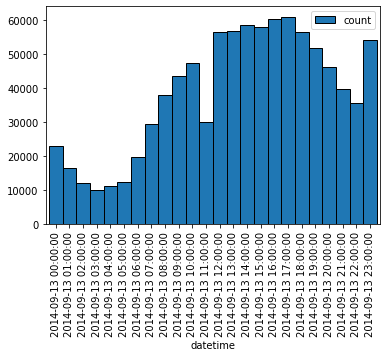

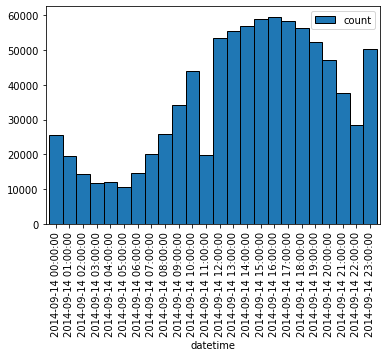

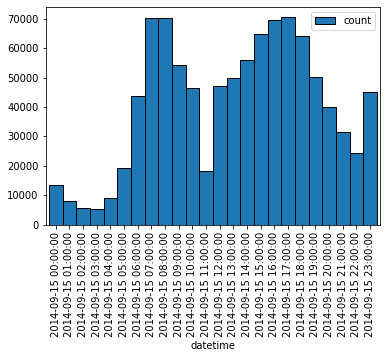

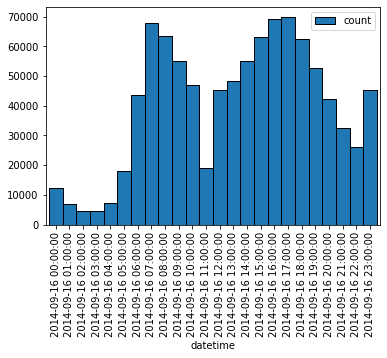

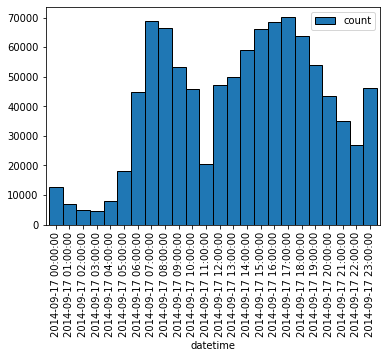

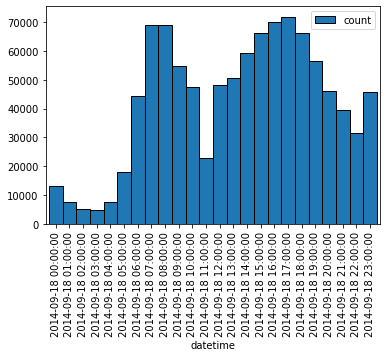

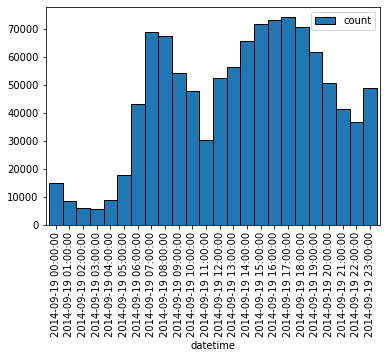

In [30]:
#loop through 7 days, plot as barplots for each hour
for i, date in enumerate(pd.date_range(start='2014-09-13', end='2014-09-19', freq='D').date, 1):
    _ = all_volume_df.loc[str(date),:].plot.bar(width=1, edgecolor='k')
    plt.show()
    #_ = day_df.iloc[i,:].plot.bar(width=1, edgecolor='k')

Traffic on all days appears to be a bimodal distribution, peaking at around 7-8 am and 5-6 pm, which perfectly aligns with morning and evening rush hours. The first two plots are a little different, with a later am peak and more overnight traffic. These two days were the weekend, which again makes sense.

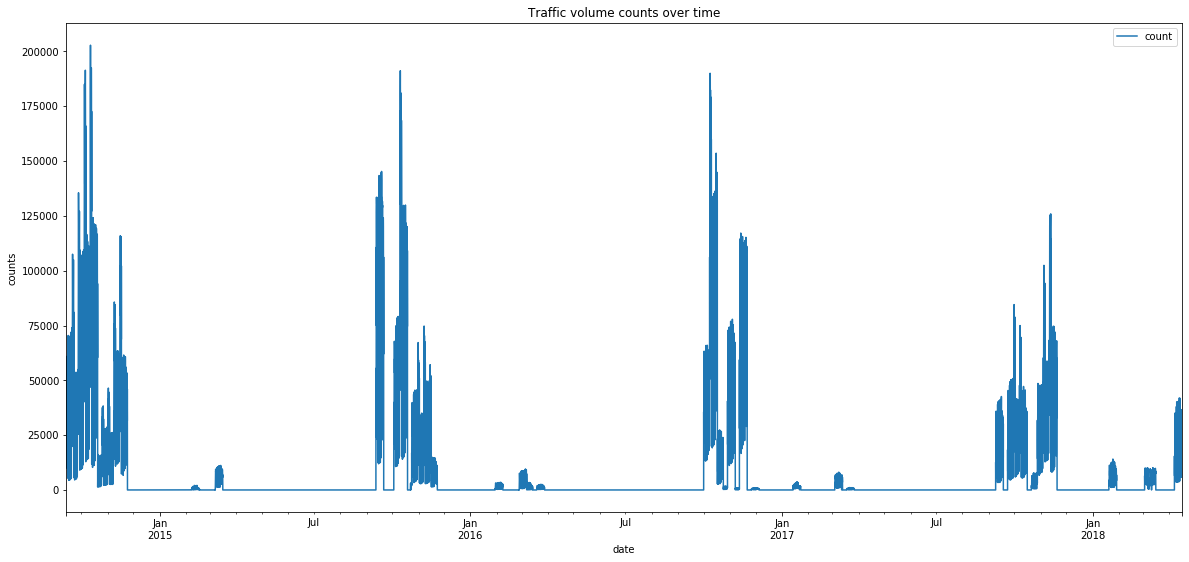

In [55]:
#plot the entire time-series
plt.rcParams["figure.figsize"] = (20, 9) # (w, h)
_ = all_volume_df.plot()
plt.title('Traffic volume counts over time')
plt.xlabel('date')
plt.ylabel('counts')
plt.savefig('volume_counts_time.png')

There are a lot of 0 values for traffic counts. It appears the counting was cyclical. It also appears that not all roads were conted on the same days. If they were, you would expect the max values to be consistent between each group, but above you can clearly see groups of small peaks between the later groups. 

In [32]:
all_volume_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31464 entries, 2014-09-13 00:00:00 to 2018-04-15 23:00:00
Data columns (total 3 columns):
date     31464 non-null object
time     31464 non-null object
count    31464 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.2+ MB


In [33]:
all_volume_df.describe()

,count
count,31464.000000
mean,8865.710336
std,24235.651594
min,0.000000
25%,0.000000
50%,0.000000
75%,709.000000
max,202827.000000


What does the distribution of counts look like?

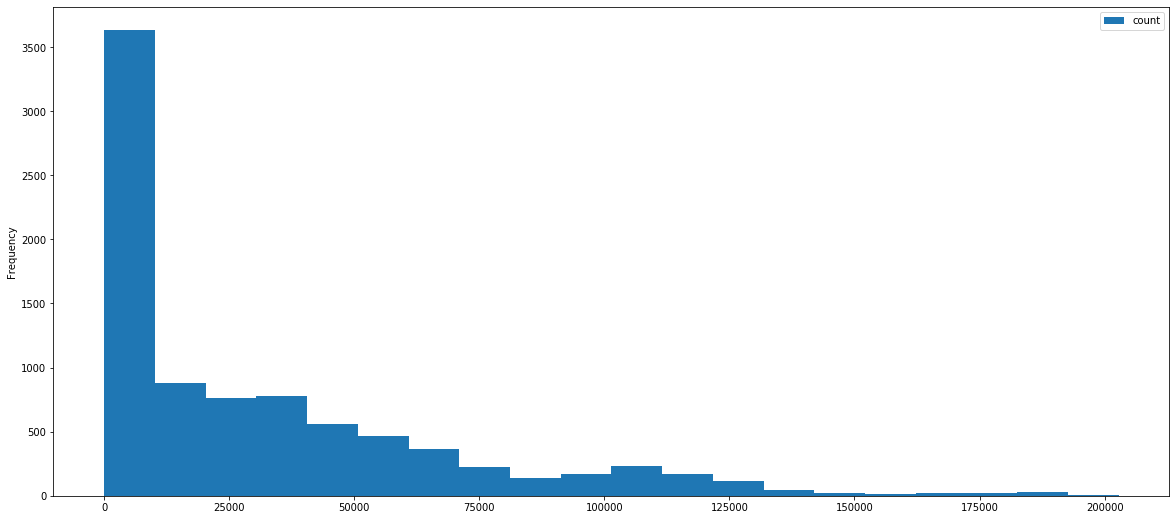

In [34]:
#Look at counts > 0
_ = all_volume_df[all_volume_df['count'] > 0].plot(kind='hist', bins=20)

How much of the data is 0?

In [35]:
#count number of rows that have no counts
zero_counts = all_volume_df[all_volume_df['count'] == 0].groupby('date').count()
total_length = len(all_volume_df.groupby('date'))
zero_length = len(zero_counts)
percent_missing = zero_length / total_length * 100
print(f'Zero valued data accounts for {percent_missing:.1f}% of total data')

Zero valued data accounts for 72.5% of total data


To help get an idea if there is any pattern to the missing data, Search through dataframe and find days where recordings were made. Look at whole day, ignore partial days. Record the day they start, and stop. Set a threshold to tighten data.

In [36]:
#Check if a day contains >= 25000 counts. If True and next day contains no counts, add date to
#'end'. If date contains >= 25000 counts and previous dat contains no counts, add date to 'start'.
# If date and next date both contain >= 25000 counts, go to next date.
active_counts = []
just_dates = []
active_counts.append({'start':'2014-09-13'}) 
just_dates.append('2014-09-13')
for i in pd.date_range(start='2014-09-13', end='2018-04-15', freq='D').date:
    if (volume_df_tidy.loc[str(i)]['count'].sum() >= 25000) & \
            (volume_df_tidy.loc[str(i + timedelta(days=1))]['count'].sum() == 0):
        active_counts.append({'end': str(i)})
        just_dates.append(str(i))
    elif (volume_df_tidy.loc[str(i)]['count'].sum() == 0) & \
            (volume_df_tidy.loc[str(i + timedelta(days=1))]['count'].sum() >= 25000):
        active_counts.append({'start': str(i + timedelta(days=1))})
        just_dates.append(str(i + timedelta(days=1)))
    else:
        next
                
             
            

In [37]:
#Convert the list of dicts into a dataframe
active_counts_df = pd.DataFrame(data=active_counts)
active_counts_df.head()
#volume_df_tidy.loc['2014-09-13':'2014-11-23']['count'].plot()

,end,start
0,NaN,2014-09-13
1,2014-11-23,NaN
2,NaN,2015-03-07
3,2015-03-15,NaN
4,NaN,2015-09-12


In [38]:
# now use dates obtained above to pull out the regions of interest from the original data
#  to call date from active_counts: active_counts_df.iloc[0]['start']
final_volume_df = pd.DataFrame()
i = 0
for i in range(0, len(active_counts), 2): # set y to i + 1 so need to increment by 2
    y = i+1
    final_volume_df = final_volume_df.append(all_volume_df.loc[just_dates[i]:just_dates[y]].copy(), \
                                             ignore_index=False)
    
final_volume_df.head()

,date,time,count
datetime,,,
2014-09-13 00:00:00,2014-09-13,00:00:00,22709
2014-09-13 01:00:00,2014-09-13,01:00:00,16322
2014-09-13 02:00:00,2014-09-13,02:00:00,12008
2014-09-13 03:00:00,2014-09-13,03:00:00,9937
2014-09-13 04:00:00,2014-09-13,04:00:00,11198


In [39]:
##testing for above



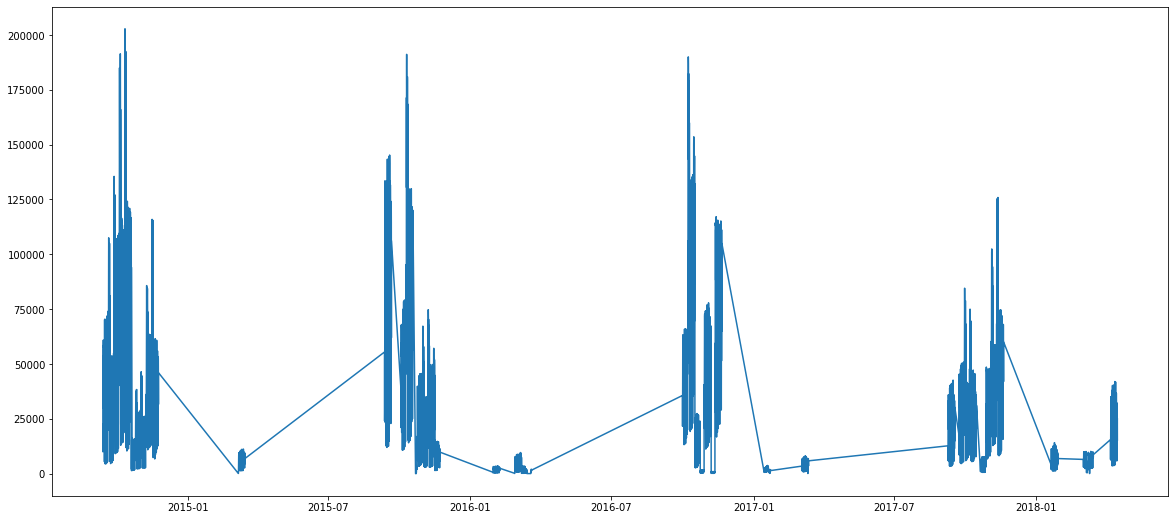

In [40]:
_ = plt.plot(final_volume_df['count'])

In [41]:
#Export full data now as a csv for overlaying with accident data
final_volume_df.to_csv(path_or_buf='final_volume_counts.csv')

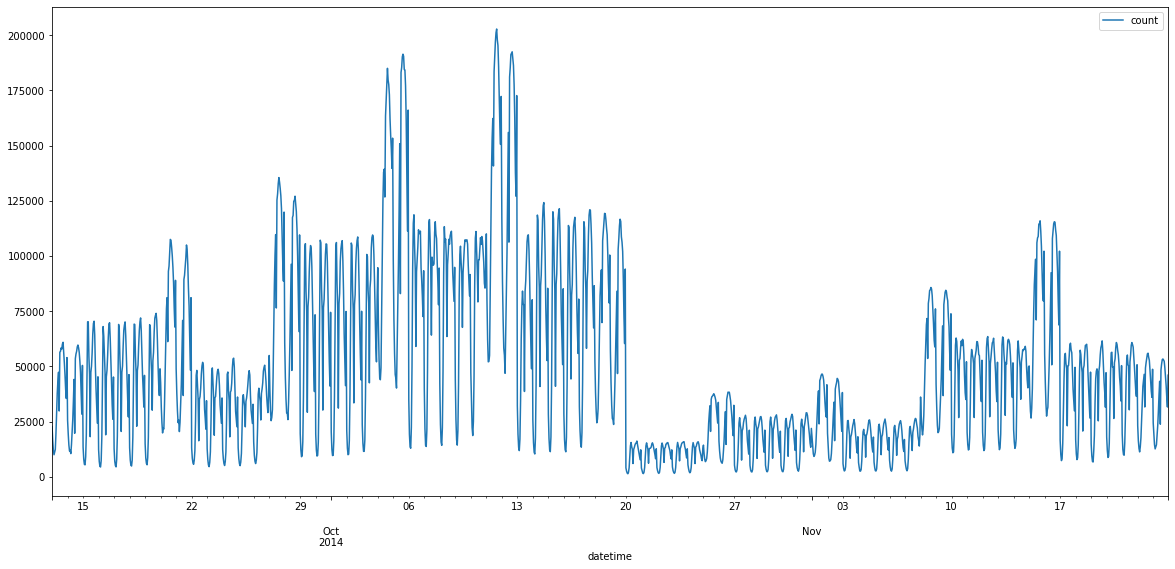

In [42]:
#Look at just the first continuous section
final_volume_df.loc['2014-09-13':'2014-11-23'].plot()

The counts are very inconsistent - the threshold I set about was for cumulative counts throughout the day. This is clearly not stringent enough. Now that I have got rid of most of the 0 days, set another criterium of 30000 counts.

In [43]:
#how many data points to work with?
len(final_volume_df[final_volume_df['count'] >= 30000])

3433

In [44]:
#Only keep rows with non-zero counts
final_volume_df = final_volume_df[final_volume_df['count'] >= 30000]


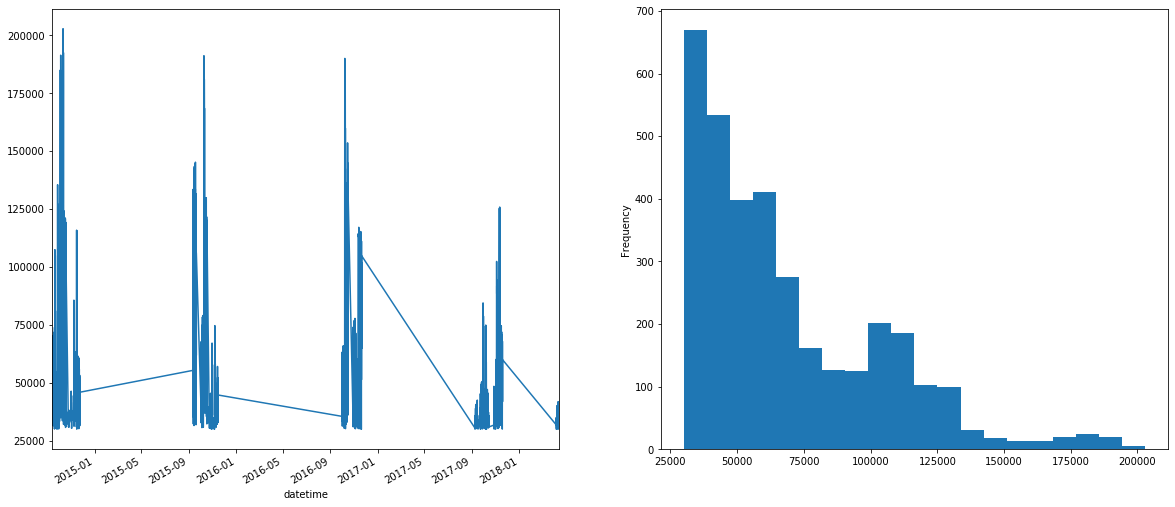

In [45]:
#final_volume_df.describe()
plt.rcParams["figure.figsize"] = (20, 9) # (w, h)
plt.subplot(1,2,1)
_ = final_volume_df['count'].plot()
plt.subplot(1,2,2)
_ = final_volume_df['count'].plot(kind='hist', bins=20)

To make aggregating data easier, I want the day of the week also included in the dataframe. Use pandas .dayofweek - Mon = 0, Sun = 6

In [46]:
final_volume_df['day_of_week'] = final_volume_df.index.dayofweek
final_volume_df.head()

,date,time,count,day_of_week
datetime,,,,
2014-09-13 08:00:00,2014-09-13,08:00:00,37724,5
2014-09-13 09:00:00,2014-09-13,09:00:00,43389,5
2014-09-13 10:00:00,2014-09-13,10:00:00,47318,5
2014-09-13 12:00:00,2014-09-13,12:00:00,56418,5
2014-09-13 13:00:00,2014-09-13,13:00:00,56776,5


In [47]:
final_volume_df.groupby(['day_of_week']).mean()

,count
day_of_week,
0,62819.962500
1,63830.349754
2,64119.141119
3,64185.382775
4,64120.351724
5,77908.191489
6,73763.547112


Text(0.5, 0, 'day of week')

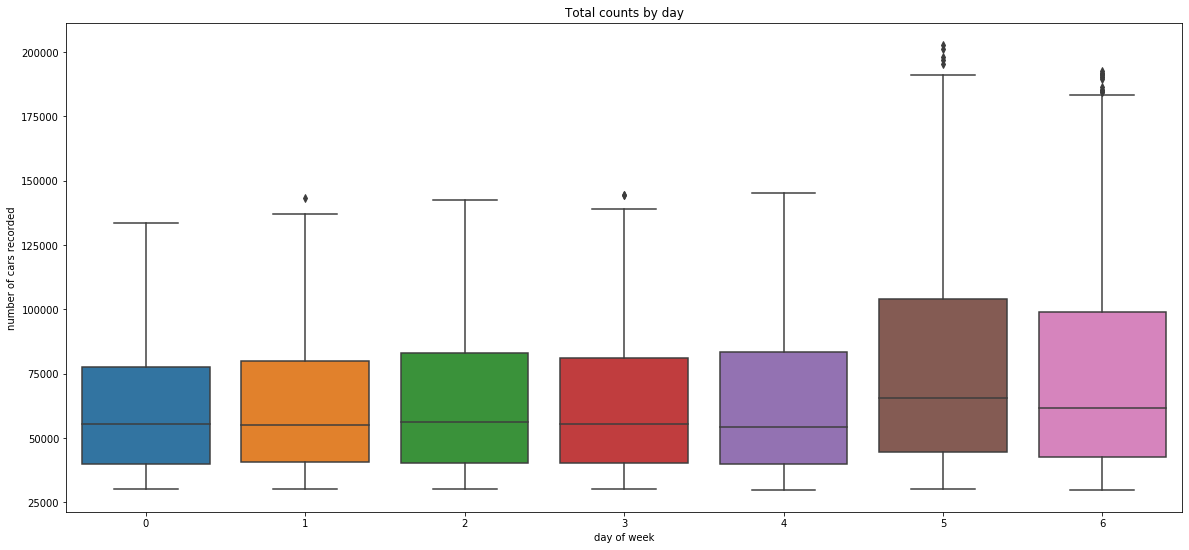

In [48]:
#plot the counts by the day of the week.
test_df = all_volume_df.reset_index()
test_df.head()
#dow = all_volume_df['day_of_week']
#count_by_day = all_volume_df['count']
_ = sns.boxplot(final_volume_df['day_of_week'], final_volume_df['count'])
_.set_title('Total counts by day')
_.set_ylabel('number of cars recorded')
_.set_xlabel('day of week')

In [49]:
#Questions: do every day of the week contain the same average number of cars?

final_volume_df.head()

,date,time,count,day_of_week
datetime,,,,
2014-09-13 08:00:00,2014-09-13,08:00:00,37724,5
2014-09-13 09:00:00,2014-09-13,09:00:00,43389,5
2014-09-13 10:00:00,2014-09-13,10:00:00,47318,5
2014-09-13 12:00:00,2014-09-13,12:00:00,56418,5
2014-09-13 13:00:00,2014-09-13,13:00:00,56776,5


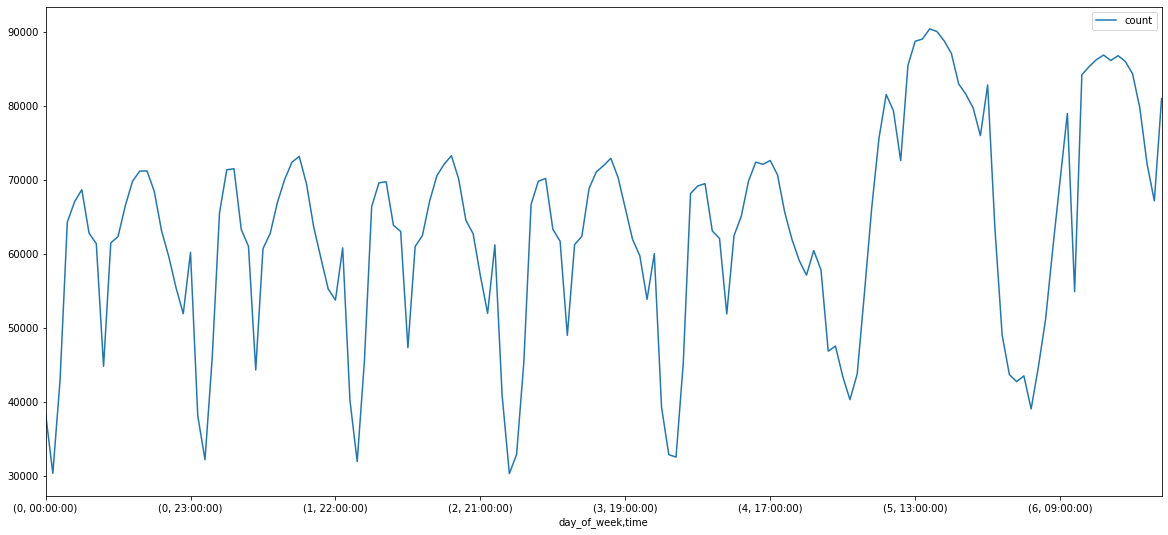

In [50]:
#Time series plot showing mean of each hour plotted per day
mean_by_hour_df = pd.DataFrame(final_volume_df['count'].groupby([final_volume_df['day_of_week'], final_volume_df['time']]).mean())
mean_by_hour_df.plot()

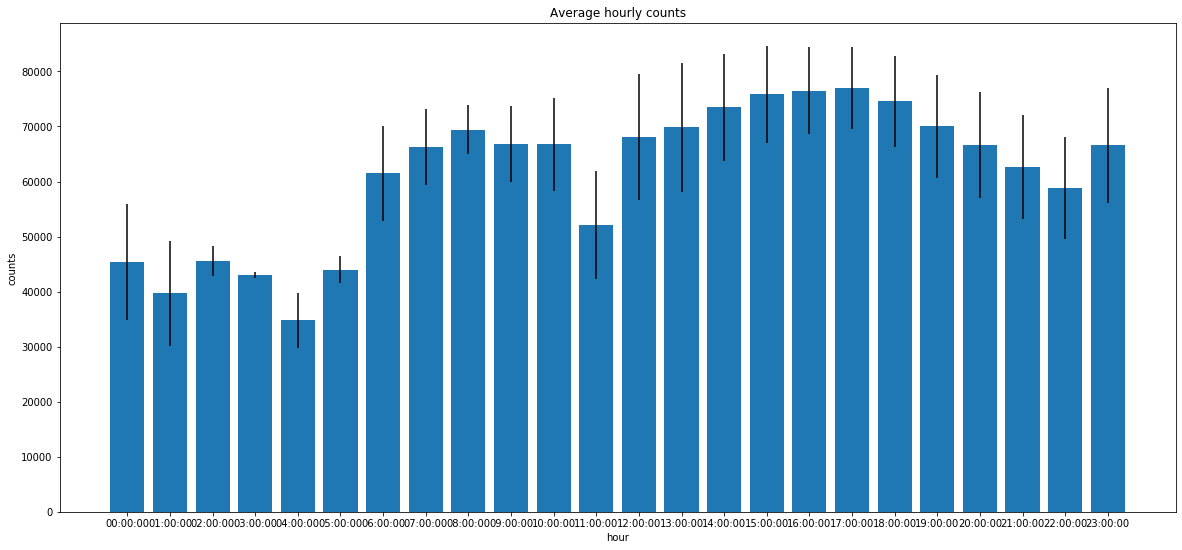

In [62]:
hourly_mean = mean_by_hour_df['count'].groupby(['time']).mean()
hourly_std = mean_by_hour_df['count'].groupby(['time']).std()
#sns.plot(x=hourly_mean.index, y = hourly_mean)
_ = plt.bar(x=hourly_mean.index, height = hourly_mean, yerr=hourly_std)
plt.title('Average hourly counts')
plt.xlabel('hour')
plt.ylabel('counts')
plt.savefig('ave_hourly_counts.png')

Above are the average values for traffic volume at each hour of the day. Now we need to divide each hour by the max value to get the percent max, which can then be applied to the traffic data.

In [52]:
hourly_volume_norm = hourly_mean / hourly_mean.max()
hourly_volume_norm.head()

time
00:00:00    0.590575
01:00:00    0.516411
02:00:00    0.592463
03:00:00    0.559711
04:00:00    0.452148
Name: count, dtype: float64

In [53]:
#create a csv file of the above series

hourly_volume_norm.to_csv(path_or_buf='hourly_volume_norm.csv', header=False)

###END